<a href="https://colab.research.google.com/github/Tender-sun/ML/blob/main/%E7%AC%AC%E5%9B%9B%E7%AB%A0%E7%AC%AC%E5%8D%81%E4%BA%8C%E9%A2%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 12. Batch Gradient Descent with early stopping for Softmax Regression
(without using Scikit-Learn)

Let's start by loading the data. We will just reuse the Iris dataset we loaded earlier.

In [ ]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

We need to add the bias term for every instance ($x_0 = 1$):

In [ ]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

And let's set the random seed so the output of this exercise solution is reproducible:

In [ ]:
np.random.seed(2042)

The easiest option to split the dataset into a training set, a validation set and a test set would be to use Scikit-Learn's `train_test_split()` function, but the point of this exercise is to try understand the algorithms by implementing them manually. So here is one possible implementation:

In [ ]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

The targets are currently class indices (0, 1 or 2), but we need target class probabilities to train the Softmax Regression model. Each instance will have target class probabilities equal to 0.0 for all classes except for the target class which will have a probability of 1.0 (in other words, the vector of class probabilities for ay given instance is a one-hot vector). Let's write a small function to convert the vector of class indices into a matrix containing a one-hot vector for each instance:

In [ ]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

Let's test this function on the first 10 instances:

In [ ]:
y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [ ]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

Looks good, so let's create the target class probabilities matrix for the training set and the test set:

In [ ]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

Now let's implement the Softmax function. Recall that it is defined by the following equation:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [ ]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

We are almost ready to start training. Let's define the number of inputs and outputs:

In [ ]:
n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)

Now here comes the hardest part: training! Theoretically, it's simple: it's just a matter of translating the math equations into Python code. But in practice, it can be quite tricky: in particular, it's easy to mix up the order of the terms, or the indices. You can even end up with code that looks like it's working but is actually not computing exactly the right thing. When unsure, you should write down the shape of each term in the equation and make sure the corresponding terms in your code match closely. It can also help to evaluate each term independently and print them out. The good news it that you won't have to do this everyday, since all this is well implemented by Scikit-Learn, but it will help you understand what's going on under the hood.

So the equations we will need are the cost function:

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

And the equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting `nan` values.

In [ ]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 5.446205811872683
500 0.8350062641405651
1000 0.6878801447192402
1500 0.6012379137693314
2000 0.5444496861981872
2500 0.5038530181431525
3000 0.47292289721922487
3500 0.44824244188957774
4000 0.4278651093928793
4500 0.41060071429187134
5000 0.3956780375390374


And that's it! The Softmax model is trained. Let's look at the model parameters:

In [ ]:
Theta

array([[ 3.32094157, -0.6501102 , -2.99979416],
       [-1.1718465 ,  0.11706172,  0.10507543],
       [-0.70224261, -0.09527802,  1.4786383 ]])

Let's make predictions for the validation set and check the accuracy score:

In [ ]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

Well, this model looks pretty good. For the sake of the exercise, let's add a bit of $\ell_2$ regularization. The following training code is similar to the one above, but the loss now has an additional $\ell_2$ penalty, and the gradients have the proper additional term (note that we don't regularize the first element of `Theta` since this corresponds to the bias term). Also, let's try increasing the learning rate `eta`.

In [ ]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 6.629842469083912
500 0.5339667976629505
1000 0.5036400750148942
1500 0.49468910594603216
2000 0.4912968418075476
2500 0.48989924700933296
3000 0.4892990598451198
3500 0.4890351244397859
4000 0.4889173621830818
4500 0.4888643337449303
5000 0.4888403120738818


Because of the additional $\ell_2$ penalty, the loss seems greater than earlier, but perhaps this model will perform better? Let's find out:

In [ ]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

Cool, perfect accuracy! We probably just got lucky with this validation set, but still, it's pleasant.

Now let's add early stopping. For this we just need to measure the loss on the validation set at every iteration and stop when the error starts growing.

In [ ]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

0 4.7096017363419875
500 0.5739711987633519
1000 0.5435638529109128
1500 0.5355752782580262
2000 0.5331959249285545
2500 0.5325946767399382
2765 0.5325460966791898
2766 0.5325460971327978 early stopping!


In [ ]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

Still perfect, but faster.

Now let's plot the model's predictions on the whole dataset:

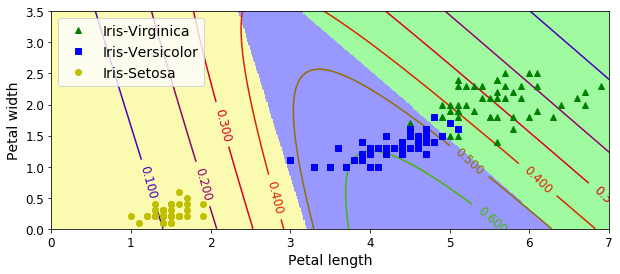

In [ ]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

And now let's measure the final model's accuracy on the test set:

In [ ]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333

Our perfect model turns out to have slight imperfections. This variability is likely due to the very small size of the dataset: depending on how you sample the training set, validation set and the test set, you can get quite different results. Try changing the random seed and running the code again a few times, you will see that the results will vary.